# Machine Learning Classification Tutorial
By: Isaac Rosenberg


In this tutorial, we will build a neural network that takes **spectra** from the SDSS catalog and classifies whether an observation shows a star, galaxy, or quasar.

<img src="../attachments/sdss.png"  width="600"/>

[Source: SDSS](https://www.sdss.org/science/image-gallery/)

Why does that matter? The Sloan Digital Sky Survey (SDSS) has collected over four million spectra. Each spectrum is the fingerprint of a cosmic object, encoding chemical composition, temperature, physical properties, and distance. But it is impossible to manually label all of them. Automating this classification helps astronomers flag interesting outliers, and build clean training sets for future science.

We will walk through the full workflow:
- get familiar with the SDSS spectra and how they differ between object types
- prepare the data so a neural network can ingest it
- train a simple classifier and evaluate how well it can tell these sources apart

By the end, you should have an intuition for what information lives in a spectrum and why machine learning is a powerful tool for extracting it at scale.


## Exploring SDSS spectra
Before training a classifier, it helps to see what raw spectra look like. Below we grab a few examples of stars, galaxies, and quasars from the SDSS sample so you can spot the broad absorption features, sharp emission lines, and continuum shapes that set them apart.


In [1]:
### IMPORTS
import numpy as np
import matplotlib.pyplot as plt
from functions import *
from collections import defaultdict
import random

In [2]:
# If you don't have some of the packages above, you can uncomment the lines below to install them.

#!pip install numpy 
#!pip install matplotlib

### Loading the SDSS sample
The spectra for this tutorial are pre-packaged in a NumPy `.npy` file. Each entry stores the wavelength grid, flux values, class label, and metadata like redshift. Loading it once keeps the rest of the notebook focused on analysis instead of I/O boilerplate.


In [3]:
# Load both parts
spectra1 = np.load('../data/sdss_spectra_part1.npy', allow_pickle=True)
spectra2 = np.load('../data/sdss_spectra_part2.npy', allow_pickle=True)

# Combine into one array
spectra = np.concatenate([spectra1, spectra2], axis=0)

### Let's look at a few spectra
Seeing real data helps anchor the classification task. Below we group the SDSS sample by label and randomly pick three representatives of each class. Pay attention to:stars show dense absorption features, galaxies reveal broader lines plus a redder continuum, and quasars explode with strong emission lines.


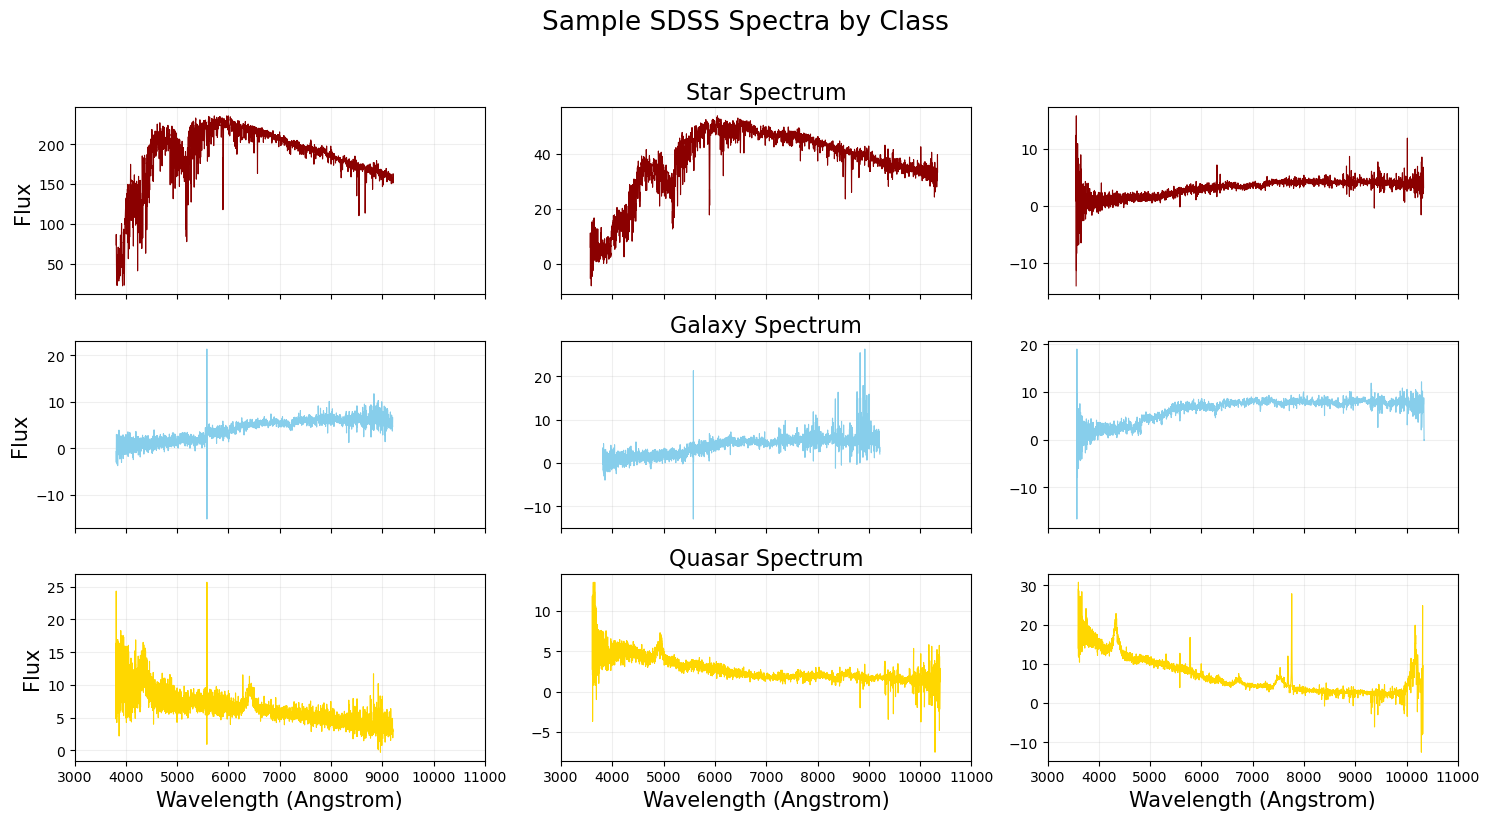

In [4]:
# Define the SDSS spectral classes we'll visualize
classes = ['STAR', 'GALAXY', 'QSO']

# Provide nicer labels for plot titles
labels = {'STAR': 'Star', 'GALAXY': 'Galaxy', 'QSO': 'Quasar'}

colors = {'STAR': 'darkred', 'GALAXY': 'skyblue', 'QSO': 'gold'}

# Group spectra by class into a dictionary.
# Each key corresponds to one class (e.g., 'STAR'),
# and each value is a list of spectra (each spectrum is a dict).
grouped = {cls: [spec for spec in spectra if spec['class'] == cls] for cls in classes}

# Create a random number generator
rng = np.random.default_rng(92)

# Create a grid of subplots: one row per class, three columns per sample
fig, axes = plt.subplots(len(classes), 3, figsize=(15, 8), sharex=True, sharey=False)

# Loop over each class (row)
for row, cls in enumerate(classes):
    available = grouped[cls]

    # Check that we have at least 3 spectra available for this class
    if len(available) < 3:
        raise ValueError(f'Not enough spectra for {cls}')

    # Randomly pick 3 unique spectra for this class
    idxs = rng.choice(len(available), size=3, replace=False)

    # Loop over the three chosen spectra and plot them
    for col, idx in enumerate(idxs):
        spec = available[idx]
        ax = axes[row, col]

        # Plot the flux vs. wavelength
        ax.plot(spec['wavelength'], spec['flux'], lw=0.8, color=colors[cls])

        # Label axes only on left and bottom panels to avoid clutter
        if row == len(classes) - 1:
            ax.set_xlabel('Wavelength (Angstrom)', fontsize=15)  # Angstroms spell out units for clarity
        if col == 0:
            ax.set_ylabel('Flux', fontsize=15)
        if col == 1:
            ax.set_title(f'{labels[cls]} Spectrum', fontsize=16)

        # Light grid and wavelength limits typical of SDSS spectra
        ax.grid(alpha=0.2)
        ax.set_xlim(3000, 11000)

# Add a figure-level title and adjust spacing
fig.suptitle('Sample SDSS Spectra by Class', fontsize=19, y=1.02)
plt.tight_layout()
plt.show()


#### Discussion: what stands out?

Qualitatively what are the differences between the three classes?


### Let's take the median


/Users/isaacrosenberg/opt/anaconda3/envs/430/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


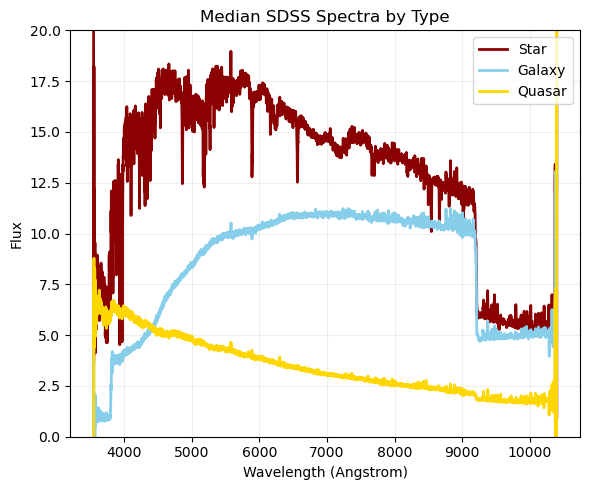

In [5]:
# Define a common wavelength grid based on all unique values
all_waves = np.unique(np.concatenate([s['wavelength'] for s in spectra]))
plt.figure(figsize=(6, 5))

for c in classes:
    specs = [s for s in spectra if s['class'] == c]
    fluxes = np.full((len(specs), len(all_waves)), np.nan)
    for i, s in enumerate(specs):
        w, f = s['wavelength'], s['flux']
        idx = np.searchsorted(all_waves, w)
        fluxes[i, idx[:len(f)]] = f
    median_flux = np.nanmedian(fluxes, axis=0)
    plt.plot(all_waves, median_flux, color=colors[c], lw=2, label=labels[c])

plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux')
plt.title('Median SDSS Spectra by Type')
plt.ylim(0,20)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


#### Discussion: comparing median shapes
- How would redshift affect these shapes?
- Why does it seem like the quasar and galaxy lines are less noisy than before?
- Is all our data reliable? What cuts should we make?

In [51]:
######### USER SETTING ##########
lambda_min = 3800
lambda_max = 9200

all_waves = np.unique(np.concatenate([s['wavelength'] for s in spectra]))
mask = (all_waves >= lambda_min) & (all_waves <= lambda_max)
wave_grid = all_waves[mask]
print(f"{len(wave_grid)} wavelengths after cut.")

3840 wavelengths after cut.


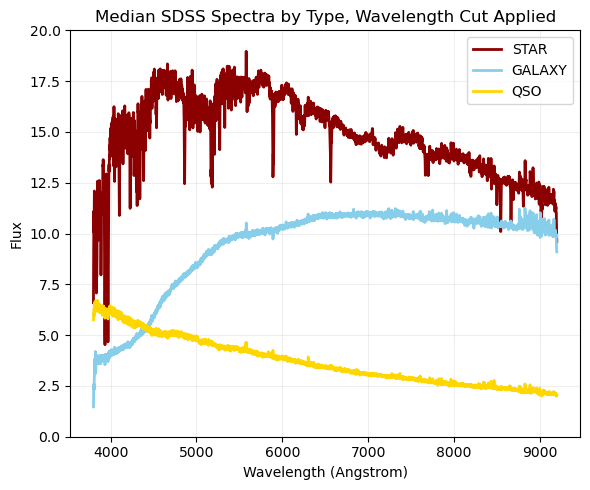

In [55]:
classes = ['STAR', 'GALAXY', 'QSO']

plt.figure(figsize=(6,5))
for c in classes:
    specs = [s for s in spectra if s['class'] == c]
    F = np.full((len(specs), len(wave_grid)), np.nan)

    for i, s in enumerate(specs):
        w, f = s['wavelength'], s['flux']
        keep = (w >= lambda_min) & (w <= lambda_max)
        w_cut, f_cut = w[keep], f[keep]
        idx = np.searchsorted(wave_grid, w_cut)
        valid = (idx<len(wave_grid)) & (wave_grid[idx]==w_cut)
        F[i, idx[valid]] = f_cut[valid]

    plt.plot(wave_grid, np.nanmedian(F, axis=0), lw=2, label=c, color=colors[c])
    
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux')
plt.title('Median SDSS Spectra by Type, Wavelength Cut Applied')
plt.ylim(0,20)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

In [65]:
# Build global wavelength grid
all_waves = np.unique(np.concatenate([s['wavelength'] for s in spectra]))
mask = (all_waves >= lambda_min) & (all_waves <= lambda_max)
wave_grid = all_waves[mask]

class_to_int = {c: i for i, c in enumerate(classes)}

X = []
y_int = []

for s in spectra:
    w, f = s['wavelength'], s['flux']

    # Cut to range
    keep = (w >= lambda_min) & (w <= lambda_max)
    w_cut, f_cut = w[keep], f[keep]

    # Allocate NaN row for missing wavelengths
    row = np.full(len(wave_grid), np.nan, dtype=np.float32)

    # Find matching wavelength positions
    idx = np.searchsorted(wave_grid, w_cut)
    valid = (idx < len(wave_grid)) & (wave_grid[idx] == w_cut)

    # Fill into aligned grid
    row[idx[valid]] = f_cut[valid]

    # Replace NaNs with 0
    row = np.nan_to_num(row)

    # Normalize
    med = np.median(row)
    if med != 0:
        row /= med

    X.append(row)
    y_int.append(class_to_int[s['class']])

X = np.vstack(X).astype(np.float32)
y_int = np.array(y_int, dtype=np.int32)
y_onehot = np.eye(len(classes))[y_int]

print("X shape:", X.shape)
print("y shape:", y_onehot.shape)


X shape: (4950, 3840)
y shape: (4950, 3)


Why are those the dimenstions of X and y. Does that make sense?

## From spectra to neural networks
With the data inspected, we can now describe a small neural network that will classify spectra.

First we need to split our data into training and testing

In [74]:
X_train, y_train_int, y_train, \
X_test,  y_test_int,  y_test = manual_train_test_split(
    X, y_int, y_onehot,
    test_fraction=0.2,
    seed=12
)

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape,  y_test.shape)


Train: (3960, 3840) (3960, 3)
Test : (990, 3840) (990, 3)


In [75]:
######### USER SETTING ##########
batch_size = 32
### This is the number of samples you will process at a time during training. ###
### Common values are between 10-100 ###

######### USER SETTING ##########
learning_rate = 0.002
### This controls how much the model's weights are updated during training. ###
### Common values are between 0.001 - 0.1 ###

########## USER SETTING ##########
hidden_layers = [128, 64, 32]
### This is a list defining the number of neurons in each hidden layer. ###
### For example, [64, 32] means two hidden layers: first with 64 neurons, second with 32 neurons. ###
### You can experiment with different architectures. ###

config, params = build(
    input_dim=X_train.shape[1],
    hidden_layers=hidden_layers,
    output_dim=len(classes),
    batch_size= batch_size,
    learning_rate=learning_rate,
    seed=12
)


In [76]:
######## USER SETTING ##########
epochs = 20
### This is the number of times the entire training dataset will be passed through the model. ###
### Common values are between 10-100 ###

params, losses, accs = train(
    X_train, y_train,
    X_test,  y_test,
    config, params,
    epochs=epochs
)

Epoch 1/20 | Loss 0.5943 | Test Acc: 83.23%
Epoch 2/20 | Loss 0.4320 | Test Acc: 87.37%
Epoch 3/20 | Loss 0.3517 | Test Acc: 88.89%
Epoch 4/20 | Loss 0.2690 | Test Acc: 89.19%
Epoch 5/20 | Loss 0.2392 | Test Acc: 91.52%
Epoch 6/20 | Loss 0.1934 | Test Acc: 93.23%
Epoch 7/20 | Loss 0.2135 | Test Acc: 93.54%
Epoch 8/20 | Loss 0.1564 | Test Acc: 93.03%
Epoch 9/20 | Loss 0.1488 | Test Acc: 94.95%
Epoch 10/20 | Loss 0.1316 | Test Acc: 94.85%
Epoch 11/20 | Loss 0.1287 | Test Acc: 95.05%
Epoch 12/20 | Loss 0.1229 | Test Acc: 94.14%
Epoch 13/20 | Loss 0.1145 | Test Acc: 94.75%
Epoch 14/20 | Loss 0.1082 | Test Acc: 94.95%
Epoch 15/20 | Loss 0.0997 | Test Acc: 95.45%
Epoch 16/20 | Loss 0.0961 | Test Acc: 95.35%
Epoch 17/20 | Loss 0.0897 | Test Acc: 95.25%
Epoch 18/20 | Loss 0.0884 | Test Acc: 95.25%
Epoch 19/20 | Loss 0.0863 | Test Acc: 95.45%
Epoch 20/20 | Loss 0.0834 | Test Acc: 95.25%


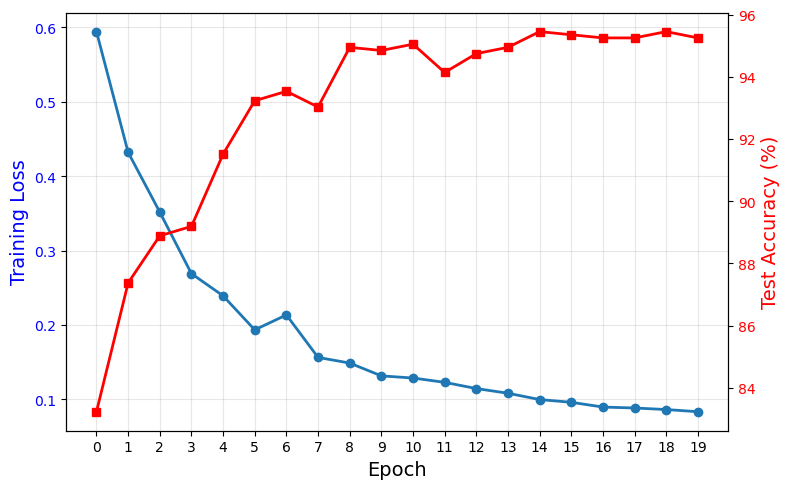

In [77]:
fig, ax1 = plt.subplots(figsize=(8,5))

# ---- LEFT AXIS: LOSS ----
ax1.plot(losses, marker='o', linewidth=2, label='Training Loss')
ax1.set_xlabel("Epoch", fontsize=14)
ax1.set_ylabel("Training Loss", fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# ---- RIGHT AXIS: ACCURACY ----
ax2 = ax1.twinx()
ax2.plot(accs, marker='s', linewidth=2, color='red', label='Test Accuracy')
ax2.set_ylabel("Test Accuracy (%)", fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# ---- FORMATTING ----
ax1.grid(alpha=0.3)
ax1.set_xticks(range(len(losses)))

fig.tight_layout()
plt.show()
